# Neural Network Models
Using the labelled Lichess data, this notebook will attempt to find a neural network which can fit that labelled data.

## Pre-requisites

### If running on Google Collab
If not running on Google collab do not run these next two cells!

In [1]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 KB 3.2 MB/s eta 0:00:00
Cloning into 'chessbot'...
remote: Enumerating objects: 535, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 535 (delta 57), reused 154 (delta 40), pack-reused 305
Receiving objects: 100% (535/535), 63.07 MiB | 12.71 MiB/s, done.
Resolving deltas: 100% (249/249), done.


In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
data_directory = working_directory

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [ ]:
!mkdir -p bin
working_directory = './bin'
data_directory = '../pre_processing/data'

## Load the Data

In [2]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import threading
from chessbot import modelinput

### Data generator For Keras

In [3]:
# There is a wierd bug here where more than one worker will cause the input data to get slightly
# messed up, however, using 1 worker seems to be infinitely faster than running this in a loop,
# which is super odd, but I'm not complaining.
def worker(input, output, input_type, start_index, num):
    input_generator = modelinput.ModelInput(input_type)
    
    for i in range(num):
        output[start_index + i] = input_generator.get_input_from_fen(input[start_index + i])

    print(f'\rThread {start_index // num} completed.', end='')

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_file, input_type, batch_size=32, pre_process=True, save_file=None, workers=1):
        self.batch_size = batch_size
        data = np.load(data_file, allow_pickle=True)
        self.y = data['y']
        self.n = len(self.y)

        if pre_process:
            self.X = np.full((len(data['X']), modelinput.ModelInput(input_type).input_length()), -1.0)
            step = self.n // workers

            threads = []
            for i in range(0, self.n, step):
                threads.append(threading.Thread(target=worker, args=(data['X'], self.X, input_type, i, step)))
                threads[-1].start()

            for i in range(workers):
                threads[i].join()
            
            if save_file != None:
                np.savez_compressed(save_file, X=self.X, y=self.y)
        else:
            self.X = data['X']

    def __len__(self):
        return math.ceil(len(self.X) / self.batch_size)

    def __getitem__(self, idx):
        # Returns one batch of data
        low = idx * self.batch_size
        high = np.minimum(low + self.batch_size, self.n)
        return self.X[low:high], self.y[low:high]

## Regression Model

### Pre-process the data

In [16]:
# Data generators for training the model
training_data = DataGenerator(data_directory + '/training_set.npz', 'positions', save_file=data_directory + '/positions_training_set.npz')
validation_data = DataGenerator(data_directory + '/validation_set.npz', 'positions', save_file=data_directory + '/positions_validation_set.npz')

Thread 0 completed.

#### Sanity check
Here we check that the training data was transformed correctly. X and y should both be in the range [0, 1].

Training data: n=100000 len(X)=100000
Validation data: n=12500 len(X)=12500


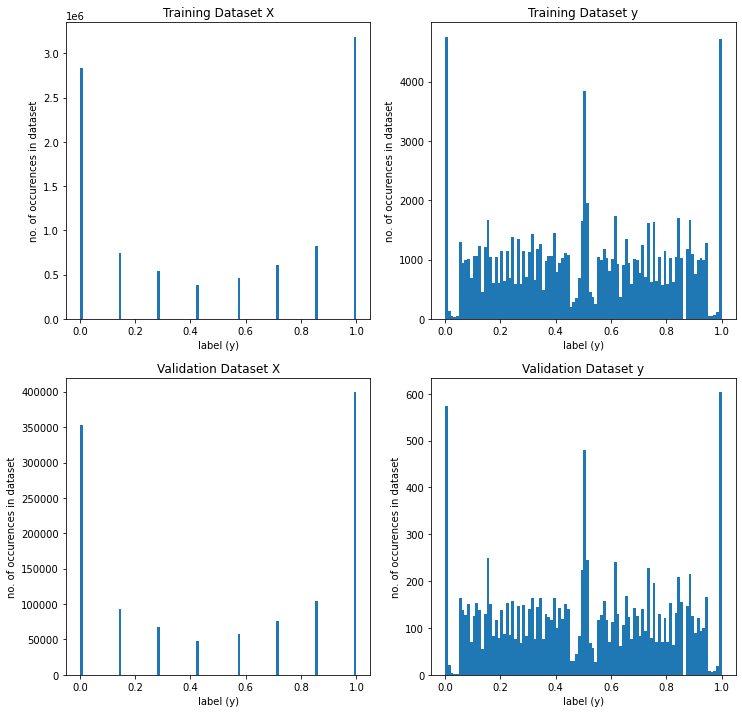

In [17]:
print(f'Training data: n={training_data.n} len(X)={len(training_data.X)}')
print(f'Validation data: n={validation_data.n} len(X)={len(validation_data.X)}')

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].hist(training_data.X.flatten(), bins=100)
ax[0, 0].set_title(f'Training Dataset X')
ax[0, 0].set_xlabel('label (y)')
ax[0, 0].set_ylabel('no. of occurences in dataset')

ax[0, 1].hist(training_data.y, bins=100)
ax[0, 1].set_title(f'Training Dataset y')
ax[0, 1].set_xlabel('label (y)')
ax[0, 1].set_ylabel('no. of occurences in dataset')

ax[1, 0].hist(validation_data.X.flatten(), bins=100)
ax[1, 0].set_title(f'Validation Dataset X')
ax[1, 0].set_xlabel('label (y)')
ax[1, 0].set_ylabel('no. of occurences in dataset')

ax[1, 1].hist(validation_data.y, bins=100)
ax[1, 1].set_title(f'Validation Dataset y')
ax[1, 1].set_xlabel('label (y)')
ax[1, 1].set_ylabel('no. of occurences in dataset')

plt.show()


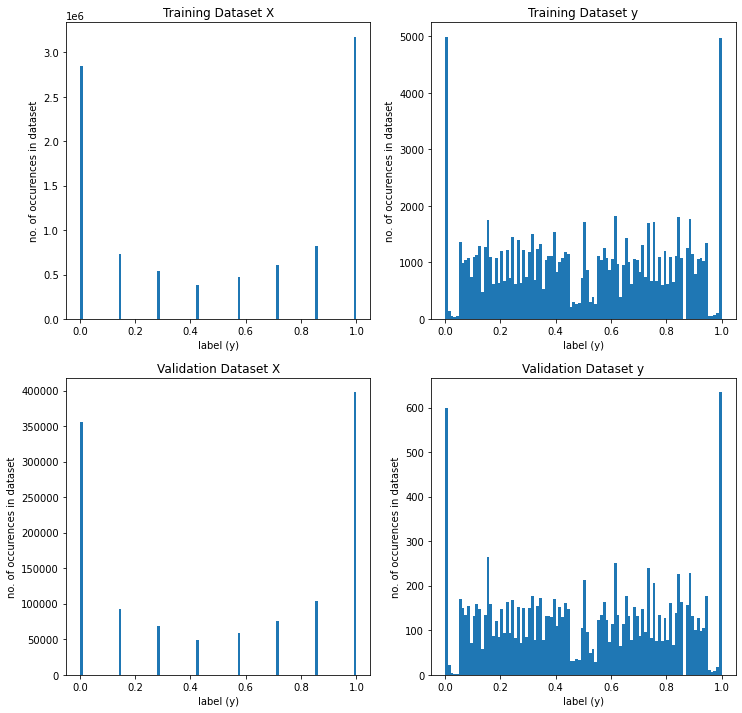

In [18]:
# Reduce the 0.5 bin by approximitly 50%
for i in range(training_data.n):
    if 0.475 < training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * training_data.n))
            training_data.y[i] = training_data.y[index]
            training_data.X[i] = training_data.X[index]

for i in range(validation_data.n):
    if 0.475 < validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * validation_data.n))
            validation_data.y[i] = validation_data.y[index]
            validation_data.X[i] = validation_data.X[index]

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

ax[0, 0].hist(training_data.X.flatten(), bins=100)
ax[0, 0].set_title(f'Training Dataset X')
ax[0, 0].set_xlabel('label (y)')
ax[0, 0].set_ylabel('no. of occurences in dataset')

ax[0, 1].hist(training_data.y, bins=100)
ax[0, 1].set_title(f'Training Dataset y')
ax[0, 1].set_xlabel('label (y)')
ax[0, 1].set_ylabel('no. of occurences in dataset')

ax[1, 0].hist(validation_data.X.flatten(), bins=100)
ax[1, 0].set_title(f'Validation Dataset X')
ax[1, 0].set_xlabel('label (y)')
ax[1, 0].set_ylabel('no. of occurences in dataset')

ax[1, 1].hist(validation_data.y, bins=100)
ax[1, 1].set_title(f'Validation Dataset y')
ax[1, 1].set_xlabel('label (y)')
ax[1, 1].set_ylabel('no. of occurences in dataset')

plt.show()

### The model we will be using

In [25]:
model = keras.Sequential([
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

## Training a Model

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.000000000001,
    verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(
    f'{working_directory}/model',
    monitor='val_loss',
    save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=f'{working_directory}/logs',
    write_graph=True,
    write_images=True,
    histogram_freq=1)

model.fit(
    training_data,
    epochs=128,
    validation_data=validation_data,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

Epoch 1/128
3125/3125 [==============================] - 17s 5ms/step - loss: 0.0813 - mean_absolute_error: 0.2356 - val_loss: 0.0759 - val_mean_absolute_error: 0.2318 - lr: 0.0010
Epoch 2/128
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0730 - mean_absolute_error: 0.2240 - val_loss: 0.0744 - val_mean_absolute_error: 0.2254 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0701 - mean_absolute_error: 0.2181 - val_loss: 0.0703 - val_mean_absolute_error: 0.2207 - lr: 0.0010
Epoch 4/128
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0679 - mean_absolute_error: 0.2134 - val_loss: 0.0696 - val_mean_absolute_error: 0.2151 - lr: 0.0010
Epoch 5/128
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0657 - mean_absolute_error: 0.2092 - val_loss: 0.0695 - val_mean_absolute_error: 0.2134 - lr: 0.0010
Epoch 6/128
3125/3125 [==============================] - 14s 4ms/step - loss: 0.0644 - mean_abs

## Model Evaluation

### Optionally load a previous model

In [ ]:
model = keras.models.load_model(f'{working_directory}/model')

### Histograms and predictions

12500/12500 [==============================] - 22s 2ms/step


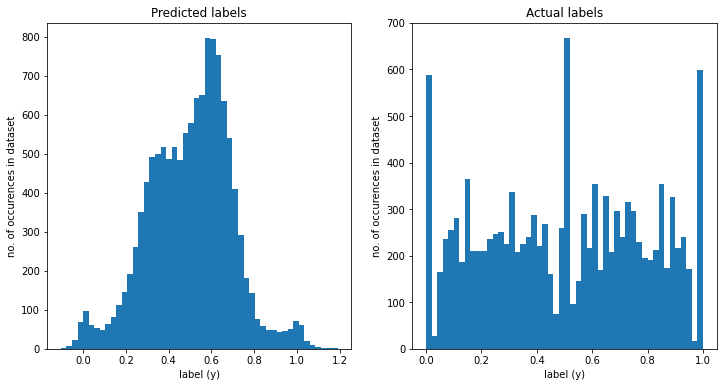

[Text(0.5, 15.0, 'Predicted label'), Text(33.0, 0.5, 'True label')]

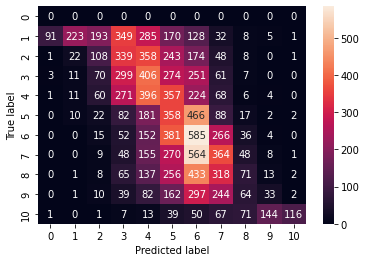

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

testing_data = DataGenerator(data_directory + '/test_set.npz', 'positions', save_file=data_directory + '/positions_test_set.npz', batch_size=1)
evaluation = model.evaluate(testing_data)
predictions = model.predict(testing_data)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(predictions, bins=50)
ax[0].set_title(f'Predicted labels')
ax[0].set_xlabel('label (y)')
ax[0].set_ylabel('no. of occurences in dataset')
ax[1].hist(testing_data.y, bins=50)
ax[1].set_title(f'Actual labels')
ax[1].set_xlabel('label (y)')
ax[1].set_ylabel('no. of occurences in dataset')
plt.show()

# Bin the data into continuous intervals, then plot a confusion matrix
predictions_binned = np.digitize(predictions, bins=np.linspace(0, 1, 10))
y_binned = np.digitize(testing_data.y, bins=np.linspace(0, 1, 10))
cm = confusion_matrix(y_binned, predictions_binned)
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set(xlabel='Predicted label', ylabel='True label')

## Why not play a game after all that training?

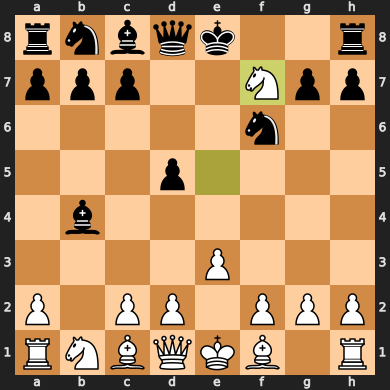

KeyboardInterrupt: ignored

In [22]:
import time
from IPython.display import clear_output
from chessbot.chessbot import ChessBot

def play_game(model, exploration_rate=0.0, should_visualise=False):
	white = ChessBot(model, chess.WHITE, exploration_rate)
	board = chess.Board()

	if should_visualise:
		display(board)

	while not board.is_game_over(claim_draw=True):
		board.push(chess.Move.from_uci(input()) if board.turn == chess.BLACK else white.move(board))

		if should_visualise:
			time.sleep(1)
			clear_output(wait=True)
			display(board)

	return board.outcome(claim_draw=True).result()
 
play_game(model, should_visualise=True)